In [11]:
import numpy as np
import matplotlib.pyplot as plt
import time

Initial positions from the NASA JPL Horizons System (https://ssd.jpl.nasa.gov/horizons/app.html#/) about the center of the Sun on January 1st, 2023 00:00:00.0000 TDB (Barycentric Dynamical Time).

In [12]:
def f_true(u, G=6.6743e-11, m1=1988500e24, m2=5.97219e24, m3=7.349e22, m4=6500):
    """Returns the output dynamics vector for a given u and t for the motion of the Sun, Earth, Moon, and 
    the James Webb Space Telescope. I.e., returns u_dot = f(u, t). 
    
    Parameters
    ----------
    u : array_like
        Current state vector [r1_x, r1_y, r1_z, r2_x, r2_y, r2_z, r3_x, r3_y, r3_z, r4_x, r4_y, r4_z, 
                              v1_x, v1_y, v1_z, v2_x, v2_y, v2_z, v3_x, v3_y, v3_z, v4_x, v4_y, v4_z]
    G : float_like
        Universal gravitational constant
    m1 : float_like
        Mass of Sun
    m2 : float_like
        Mass of Earth
    m3 : float_like
        Mass of Moon
    m4 : float_like
        Mass of JWST
    
        
    Returns
    -------
    u_dot : array
        Vector of output dynamics for a given u and t, where the first 12 elements represent the dyanmics 
        of the x-, y-, and z-positions of the Sun, Earth, Moon, and JWST; and the final 12 elements represent 
        the dyanmics of the x-, y-, and z-velocities of the Sun, Earth, Moon, and JWST 
        [v1_x, v1_y, v1_z, v2_x, v2_y, v2_z, v3_x, v3_y, v3_z, v4_x, v4_y, v4_z, 
         vdot1_x, vdot1_y, vdot1_z, vdot2_x, vdot2_y, vdot2_z, vdot3_x, vdot3_y, vdot3_z, vdot4_x, vdot4_y, vdot4_z]
    
    """
    r1 = np.array([u[0], u[1], u[2]])
    
    r2 = np.array([u[3], u[4], u[5]])
    
    r3 = np.array([u[6], u[7], u[8]])
    
    r4 = np.array([u[9], u[10], u[11]])
    
    v_dot1 = G*m2*(r2-r1)/(np.linalg.norm(r2-r1)**3) + G*m3*(r3-r1)/(np.linalg.norm(r3-r1)**3) + \
    G*m4*(r4-r1)/(np.linalg.norm(r4-r1)**3)
    
    v_dot2 = G*m1*(r1-r2)/(np.linalg.norm(r1-r2)**3) + G*m3*(r3-r2)/(np.linalg.norm(r3-r2)**3) + \
    G*m4*(r4-r2)/(np.linalg.norm(r4-r2)**3)
    
    v_dot3 = G*m1*(r1-r3)/(np.linalg.norm(r1-r3)**3) + G*m2*(r2-r3)/(np.linalg.norm(r2-r3)**3) + \
    G*m4*(r4-r3)/(np.linalg.norm(r4-r3)**3)
        
    v_dot4 = G*m1*(r1-r4)/(np.linalg.norm(r1-r4)**3) + G*m2*(r2-r4)/(np.linalg.norm(r2-r4)**3) + \
    G*m3*(r3-r4)/(np.linalg.norm(r3-r4)**3)
    
    u_dot = np.array([u[12], u[13], u[14], u[15], u[16], u[17], u[18], u[19], u[20], u[21], u[22], u[23], \
                     v_dot1[0], v_dot1[1], v_dot1[2], v_dot2[0], v_dot2[1], v_dot2[2], v_dot3[0], v_dot3[1], \
                      v_dot3[2], v_dot4[0], v_dot4[1], v_dot4[2]])
    return u_dot

In [13]:
def rk4(u_k, delta_t):
    y1 = f_true(u_k)
    y2 = f_true(u_k + 0.5*delta_t*y1)
    y3 = f_true(u_k + 0.5*delta_t*y2)
    y4 = f_true(u_k + delta_t*y3)
    u_kplus1 = u_k + (1/6)*delta_t*(y1 + 2*y2 + 2*y3 + y4)
    return u_kplus1

def ivp_rk4(u_0, T, delta_t):
    
    K = int(T/delta_t)
    times = np.zeros(K+1)
    times[0] = 0
    u = np.zeros((K+1, 24))
    u[0] = u_0
    for i in range(1, K+1):
        times[i] = times[i-1] + delta_t
        u[i] = rk4(u[i-1], delta_t)
    return u, times

Forward Euler

In [14]:
def forward_euler(u_k, delta_t):
    u_kplus1=[]
    u_kplus1= (u_k+ delta_t*f_true(u_k))
    return u_kplus1

def ivp_forward_euler(u_0, T, delta_t):
    
    K = int(T/delta_t)
    N = len(u_0)
    times= np.linspace(0,T, K+1)
    u=np.zeros((K+1, N))
    
    for i in range(K+1):
        if i == 0:
            u[i]=u_0
        else:
            u[i]= forward_euler(u[i-1], delta_t)
    return u, times

def ivp_forward_euler_error(u_0, T, delta_t, delta_t_baseline):
    u_dt, times_dt = ivp_forward_euler(u_0, T, delta_t)
    uf_dt = u_dt[-1]
    
    # predict final state using delta_t_baseline
    u_dtb, times_dtb = ivp_forward_euler(u_0, T, delta_t_baseline)
    uf_dtb = u_dtb[-1]
    
    # calculate error
    err = np.linalg.norm(uf_dt-uf_dtb)/np.linalg.norm(uf_dtb)
    return err

AB2

In [15]:
def ab2(u_km1, u_k, delta_t):

    u_kplus1 = u_k + (delta_t/2)*(-f_true(u_km1) + 3*f_true(u_k))
    #print(u_kplus1)
    return u_kplus1

def ivp_ab2(u_0, T, delta_t):
  
    K = int(T/delta_t)
    N = len(u_0)

    u = np.zeros((K+1,N))
    times = np.linspace(0, T, K+1)
    

    u[0] = u_0
    #print(u[0])
    u[1] = rk4(u[0], delta_t) 
    #print(u[1])
    
    for i in range(2,K+1):
            u[i] = ab2(u[i-2], u[i-1], delta_t)
            
    return u, times

def ivp_ab2_error(u_0, T, delta_t, delta_t_baseline):
 
    # predict final state using delta_t
    u_dt, times_dt = ivp_ab2(u_0, T, delta_t)
    uf_dt = u_dt[-1]
    
    # predict final state using delta_t_baseline
    u_dtb, times_dtb = ivp_ab2(u_0, T, delta_t_baseline)
    uf_dtb = u_dtb[-1]
    
    # calculate error
    err = np.linalg.norm(uf_dt - uf_dtb)/np.linalg.norm(uf_dtb)
    #print(err)
    return(err)

AB3

In [16]:
def ab3(u_k, u_kminus1, u_kminus2, delta_t):
    
    u_kplus1 = u_k + (delta_t/12)*(5*f_true(u_kminus2) - 16*f_true(u_kminus1) + 23*f_true(u_k))
    return u_kplus1
                                   
def ivp_ab3(u_0, T, delta_t):
    u_rk4, times_rk4 = ivp_rk4(u_0, T, delta_t)
    u_1 = u_rk4[1]
    u_2 = u_rk4[2]
                               
    K = int(T/delta_t)
    times = np.zeros(K+1)
    times[0] = 0
    times[1] = delta_t
    times[2] = 2*delta_t
    u = np.zeros((K+1, 24))
    u[0] = u_0
    u[1] = u_1
    u[2] = u_2
    for i in range(3, K+1):
        times[i] = times[i-1] + delta_t
        u[i] = ab3(u[i-1], u[i-2], u[i-3], delta_t)
        
    return u, times

def ivp_ab3_error(u_0, T, delta_t, delta_t_baseline):
    
    # predict final state using delta_t
    u, times = ivp_ab3(u_0, T, delta_t)
    u_final_delta_t = u[-1]

    # predict final state using delta_t_baseline
    u_baseline, times_b = ivp_ab3(u_0, T, delta_t_baseline)
    u_final_delta_t_baseline = u_baseline[-1]

    # calculate error
    err = np.linalg.norm(u_final_delta_t - u_final_delta_t_baseline)/np.linalg.norm(u_final_delta_t_baseline)
    return err

AB4

In [17]:
def ab4(u_k, u_kminus1, u_kminus2, u_kminus3, delta_t):

    u_kplus1 = u_k + (delta_t/24)*(55*f_true(u_k) - 59*f_true(u_kminus1) + 37*f_true(u_kminus2) - 9*f_true(u_kminus3))
    return u_kplus1
                                   
def ivp_ab4(u_0, T, delta_t):
    u_rk4, times_rk4 = ivp_rk4(u_0, T, delta_t)
    u_1 = u_rk4[1]
    u_2 = u_rk4[2]
    u_3 = u_rk4[3]
                               
    K = int(T/delta_t)
    times = np.zeros(K+1)
    times[0] = 0
    times[1] = delta_t
    times[2] = 2*delta_t
    times[3] = 3*delta_t
    
    u = np.zeros((K+1, 24))
    u[0] = u_0
    u[1] = u_1
    u[2] = u_2
    u[3] = u_3
    for i in range(4, K+1):
        times[i] = times[i-1] + delta_t
        u[i] = ab4(u[i-1], u[i-2], u[i-3], u[i-4], delta_t)
        
    return u, times

def ivp_ab4_error(u_0, T, delta_t, delta_t_baseline):
    # predict final state using delta_t
    u, times = ivp_ab4(u_0, T, delta_t)
    u_final_delta_t = u[-1]

    # predict final state using delta_t_baseline
    u_baseline, times_b = ivp_ab4(u_0, T, delta_t_baseline)
    u_final_delta_t_baseline = u_baseline[-1]

    # calculate error
    err = np.linalg.norm(u_final_delta_t - u_final_delta_t_baseline)/np.linalg.norm(u_final_delta_t_baseline)
    return err

Initial positions from the NASA JPL Horizons System (https://ssd.jpl.nasa.gov/horizons/app.html#/) about the center of the Sun beginning on January 1st, 2023 00:00:00.0000 TDB (Barycentric Dynamical Time) and continuing for 2-month increments.

In [18]:
#January 1

r1xa = 0.0
r1ya = 0.0
r1za = 0.0
v1xa = 0.0
v1ya = 0.0
v1za = 0.0

r2xa = -2.546993054069973e10
r2ya = 1.448833649541957e11
r2za = -7.309393196061254e6
v2xa = -2.981645982255353e4
v2ya = -5.280336055653292e3
v2za = -6.389863380211747e-1

r3xa = -2.514444592038248e10
r3ya = 1.450973275129817e11
r3za = -1.223136855439097e7
v3xa = -3.032118810660499e4
v3ya = -4.414326457914513e3
v3za = 8.710958230757004e1

r4xa = -2.578250249393511e10
r4ya = 1.464907704121326e11
r4za = -4.584538122908324e8
v4xa = -2.986568092220365e4
v4ya = -5.280136611161322e3
v4za = -2.124512532013934e1

u_0a = np.array([r1xa, r1ya, r1za, r2xa, r2ya, r2za, r3xa, r3ya, r3za, r4xa, r4ya, r4za, \
                v1xa, v1ya, v1za, v2xa, v2ya, v2za, v3xa, v3ya, v3za, v4xa, v4ya, v4za])

In [19]:
#March 1

r1xb = 0.0
r1yb = 0.0
r1zb = 0.0
v1xb = 0.0
v1yb = 0.0
v1zb = 0.0

r2xb = -1.390908916636989e11
r2yb = 5.114278571637648e10
r2zb = -2.248861826263368e6
v2xb = -1.075299172800622e4
v2yb = -2.807252574111373e4
v2zb =  8.567250012969652e-1

r3xb = -1.390792531856891e11
r3yb = 5.154347089829262e10
r3zb = 2.621912425784767e7
v3xb = -1.172304774012434e4
v3yb = -2.801315535830740e4
v3zb = 5.544454256196119e1

r4xb = -1.400396791982681e11
r4yb = 5.221810667387206e10
r4zb = 4.841244401267916e7
v4xb = -1.09601076895989e4
v4yb = -2.840539663649154e4
v4zb = 1.665480791274483e2

u_0b = np.array([r1xb, r1yb, r1zb, r2xb, r2yb, r2zb, r3xb, r3yb, r3zb, r4xb, r4yb, r4zb, \
                 v1xb, v1yb, v1zb, v2xb, v2yb, v2zb, v3xb, v3yb, v3zb, v4xb, v4yb, v4zb])

In [20]:
#May 1

r1xc = 0.0
r1yc = 0.0
r1zc = 0.0
v1xc = 0.0
v1yc = 0.0
v1zc = 0.0

r2xc = -1.153294268395961e11
r2yc = -9.698923507961325e10
r2zc = 5.365641214370728e6
v2xc = 1.869115640734410e4
v2yc = -2.290111205194660e4
v2zc = 1.838095786334648

r3xc = -1.157132196503035e11
r3yc = -9.688087503447081e10
r3zc = 3.336895158548653e7
v3xc = 1.845615713772935e4
v3yc = -2.385180610103010e4
v3zc = -5.913411461249574e1

r4xc = -1.158687658418592e11
r4yc = -9.833383397731984e10
r4zc = 1.518385554450303e8
v4xc = 1.897918648351591e4
v4yc = -2.317013555082150e4
v4zc = -1.436696061973368e2

u_0c = np.array([r1xc, r1yc, r1zc, r2xc, r2yc, r2zc, r3xc, r3yc, r3zc, r4xc, r4yc, r4zc, \
                 v1xc, v1yc, v1zc, v2xc, v2yc, v2zc, v3xc, v3yc, v3zc, v4xc, v4yc, v4zc])

In [21]:
#July 1

r1xd = 0.0
r1yd = 0.0
r1zd = 0.0
v1xd = 0.0
v1yd = 0.0
v1zd = 0.0

r2xd = 2.280074363765381e10
r2yd = -1.503657946105490e11
r2zd = 7.987833404079080e6
v2xd = 2.895589676982078e4
v2yd = 4.356617384563205e3
v2zd = 5.256114579128557e-1

r3xd = 2.264293407208087e10
r3yd = -1.507025319731529e11
r3zd = -1.011742592421919e7
v3xd = 2.993772594608457e4
v3yd = 3.971168718206136e3
v3zd = -7.382599215946506e1

r4xd = 2.303987125047029e10
r4yd = -1.520425918267764e11
r4zd = -4.418151174276769e8
v4xd = 2.900515309357336e4
v4yd = 4.358395502431117e3
v4zd = -1.681216319865020e1

u_0d = np.array([r1xd, r1yd, r1zd, r2xd, r2yd, r2zd, r3xd, r3yd, r3zd, r4xd, r4yd, r4zd, \
                 v1xd, v1yd, v1zd, v2xd, v2yd, v2zd, v3xd, v3yd, v3zd, v4xd, v4yd, v4zd])

In [22]:
#September 1

r1xe = 0.0
r1ye = 0.0
r1ze = 0.0
v1xe = 0.0
v1ye = 0.0
v1ze = 0.0

r2xe = 1.400066731258702e11
r2ye = -5.656864340673850e10
r2ze = 2.358117319162935e6
v2xe = 1.067162823598215e4
v2ye = 2.749391621702505e4
v2ze = -2.523332735046679

r3xe = 1.403609762814817e11
r3ye = -5.662308061012682e10
r3ze = -1.573596420280263e7
v3xe = 1.087096267636243e4
v3ye = 2.856937495324895e4
v3ze = 7.689097546768231e1

r4xe = 1.409385755484925e11
r4ye = -5.766803177263514e10
r4ze = 6.937369264584780e7
v4xe = 1.087944925413747e4
v4ye = 2.785090337443807e4
v4ze = 1.545435774150192e2

u_0e = np.array([r1xe, r1ye, r1ze, r2xe, r2ye, r2ze, r3xe, r3ye, r3ze, r4xe, r4ye, r4ze, \
                 v1xe, v1ye, v1ze, v2xe, v2ye, v2ze, v3xe, v3ye, v3ze, v4xe, v4ye, v4ze])

In [23]:
#November 1

r1xf = 0.0
r1yf = 0.0
r1zf = 0.0
v1xf = 0.0
v1yf = 0.0
v1zf = 0.0

r2xf = 1.170700729451875e11
r2yf = 9.137254434320323e10
r2zf = -6.170771880961955e6
v2xf = -1.880193203813555e4
v2yf = 2.336725630074612e4
v2zf = -1.901526195551284

r3xf = 1.171497117584531e11
r3yf = 9.174793030235037e10
r3zf = 2.224828176020458e7
v3xf = -1.978706130536352e4
v3yf = 2.363622056907192e4
v3zf = 5.832889538251784e1

r4xf = 1.176317712911201e11
r4yf = 9.271128120758335e10
r4zf = 1.174109853441641e8
v4xf = -1.909537716979411e4
v4yf = 2.362269849187803e4
v4zf = -1.452123541330508e2

u_0f = np.array([r1xf, r1yf, r1zf, r2xf, r2yf, r2zf, r3xf, r3yf, r3zf, r4xf, r4yf, r4zf, \
                 v1xf, v1yf, v1zf, v2xf, v2yf, v2zf, v3xf, v3yf, v3zf, v4xf, v4yf, v4zf])

Finding state vectors for each 2-month time span and splicing them together.

In [24]:
Tt = 31536000 #365 days
Ta = 5088960 #58 days: Jan 2 - Feb 28
Tb = 5261760 #60 days: Mar 2 - Apr 30
Tc = 5261760 #60 days: May 2 - Jun 30
Td = 5348160 #61 days: Jul 2 - Aug 31
Te = 5261760 #60 days: Sep 2 - Oct 31
Tf = 5261760 #60 days: Nov 2 - Dec 31
delta_t = 8640
delta_tt = 864

ua, timesa = ivp_ab4(u_0a, Ta, delta_t)
ub, timesb = ivp_ab4(u_0b, Tb, delta_t)
uc, timesc = ivp_ab4(u_0c, Tc, delta_t)
ud, timesd = ivp_ab4(u_0d, Td, delta_t)
ue, timese = ivp_ab4(u_0e, Te, delta_t)
uf, timesf = ivp_ab4(u_0f, Tf, delta_t)
ut, timest = ivp_ab4(u_0a, Tt, delta_tt)

ux_earth = np.block([ua[:,3],ub[:,3], uc[:,3], ud[:,3], ue[:,3], uf[:,3]])
uy_earth = np.block([ua[:,4],ub[:,4], uc[:,4], ud[:,4], ue[:,4], uf[:,4]])
uz_earth = np.block([ua[:,5],ub[:,5], uc[:,5], ud[:,5], ue[:,5], uf[:,5]])

ux_moon = np.block([ua[:,6],ub[:,6], uc[:,6], ud[:,6], ue[:,6], uf[:,6]])
uy_moon = np.block([ua[:,7],ub[:,7], uc[:,7], ud[:,7], ue[:,7], uf[:,7]])
uz_moon = np.block([ua[:,8],ub[:,8], uc[:,8], ud[:,8], ue[:,8], uf[:,8]])

ux = np.block([ua[:,9], ub[:,9], uc[:,9], ud[:,9], ue[:,9], uf[:,9]])
uy = np.block([ua[:,10], ub[:,10], uc[:,10], ud[:,10], ue[:,10], uf[:,10]])
uz = np.block([ua[:,11], ub[:,11], uc[:,11], ud[:,11], ue[:,11], uf[:,11]])

Finding the position of the JWST relative to L2.

In [25]:
unit_earth = np.zeros((int(Tt/delta_t), 3))
L2_pos = np.zeros((int(Tt/delta_t), 3))
for j in range(int(Tt/delta_t)):
    earth_j = np.array([ux_earth[j], uy_earth[j], uz_earth[j]])
    unit_earth[j] = earth_j/np.sqrt(ux_earth[j]**2 + uy_earth[j]**2 + uz_earth[j]**2)
    L2_pos[j] = earth_j + 1500000000*unit_earth[j]
    
jwst_rel_L2 = np.array([ux-L2_pos[:,0], uy-L2_pos[:,1], uz-L2_pos[:,2]])

Plot original orbit of JWST

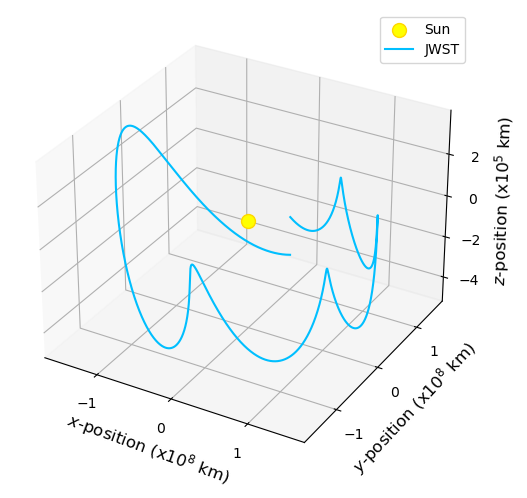

In [26]:
fig = plt.figure(figsize=(8, 6))
ax1 = plt.axes(projection='3d')
ax1.xaxis.set_rotate_label(False) 
ax1.yaxis.set_rotate_label(False) 
ax1.zaxis.set_rotate_label(False) 
ax1.set_xlabel('$x$-position (x10$^8$ km)', fontsize=12, rotation=-20)
ax1.set_ylabel('$y$-position (x10$^8$ km)', fontsize=12, rotation=47)
ax1.set_zlabel('$z$-position (x10$^5$ km)', fontsize=12, rotation=88)
ax1.scatter(0, 0, 0, c = 'yellow', edgecolors = 'gold', label = 'Sun', s = 100)
ax1.set_xticks([-1, 0, 1])
ax1.set_yticks([-1, 0, 1])
ax1.set_zticks([-4, -2, 0, 2, 4])
ax1.plot3D(ut[:,9]/(1e11), ut[:,10]/(1e11), ut[:,11]/(1e8), 'deepskyblue', label = 'JWST')
ax1.legend()
plt.show()

Plot orbit of JWST with current technique

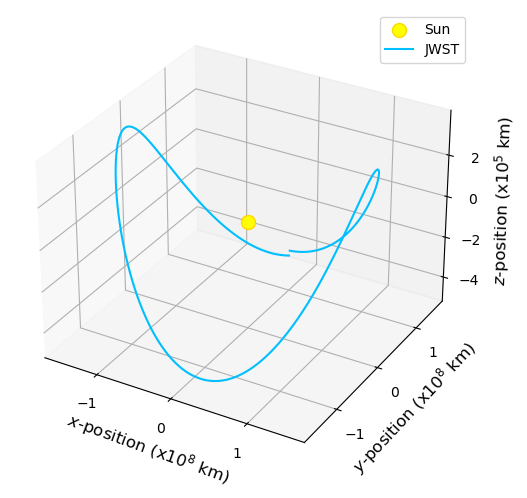

In [27]:
fig = plt.figure(figsize=(8, 6))
ax1 = plt.axes(projection='3d')
ax1.xaxis.set_rotate_label(False) 
ax1.yaxis.set_rotate_label(False) 
ax1.zaxis.set_rotate_label(False) 
ax1.set_xlabel('$x$-position (x10$^8$ km)', fontsize=12, rotation=-20)
ax1.set_ylabel('$y$-position (x10$^8$ km)', fontsize=12, rotation=47)
ax1.set_zlabel('$z$-position (x10$^5$ km)', fontsize=12, rotation=88)
ax1.scatter(0, 0, 0, c = 'yellow', edgecolors = 'gold', label = 'Sun', s = 100)
ax1.set_xticks([-1, 0, 1])
ax1.set_yticks([-1, 0, 1])
ax1.set_zticks([-4, -2, 0, 2, 4])
ax1.plot3D(ux/(1e11), uy/(1e11), uz/(1e8), 'deepskyblue', label = 'JWST')
ax1.legend()
plt.show()

Plot orbit of JWST with Earth and Moon

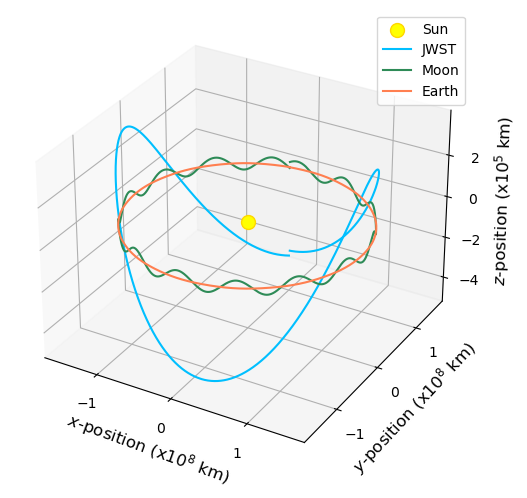

In [28]:
fig = plt.figure(figsize=(8, 6))
ax2 = plt.axes(projection='3d')
ax2.xaxis.set_rotate_label(False) 
ax2.yaxis.set_rotate_label(False) 
ax2.zaxis.set_rotate_label(False) 
ax2.set_xlabel('$x$-position (x10$^8$ km)', fontsize=12, rotation=-20)
ax2.set_ylabel('$y$-position (x10$^8$ km)', fontsize=12, rotation=47)
ax2.set_zlabel('$z$-position (x10$^5$ km)', fontsize=12, rotation=88)
ax2.scatter(0, 0, 0, c = 'yellow', edgecolors = 'gold', label = 'Sun', s = 100)
ax2.set_xticks([-1, 0, 1])
ax2.set_yticks([-1, 0, 1])
ax2.set_zticks([-4, -2, 0, 2, 4])
ax2.plot3D(ux/(1e11), uy/(1e11), uz/(1e8), 'deepskyblue', label = 'JWST')
ax2.plot3D(ux_moon/(1e11), uy_moon/(1e11), uz_moon/(1e8), 'seagreen', label = 'Moon')
ax2.plot3D(ux_earth/(1e11), uy_earth/(1e11), uz_earth/(1e8), 'coral', label = 'Earth')
ax2.legend()
plt.show()

Plot 2D orbits of JWST

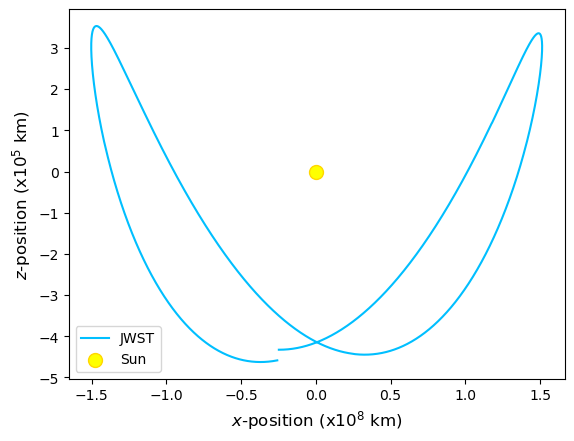

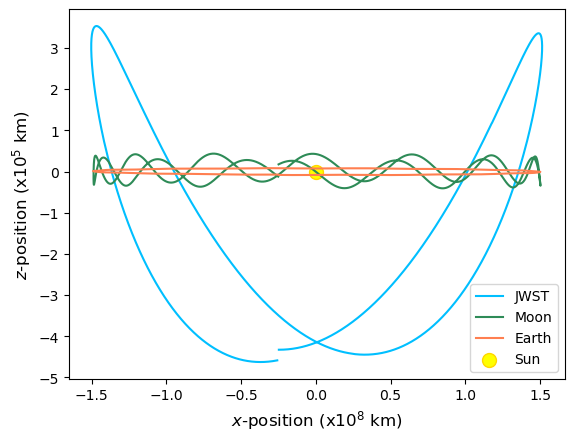

In [29]:
plt.plot(ux/(1e11), uz/(1e8), 'deepskyblue', label = 'JWST')
plt.scatter(0, 0, c = 'yellow', edgecolors = 'gold', label = 'Sun', s = 100)
plt.xlabel('$x$-position (x10$^8$ km)', size = 12)
plt.ylabel('$z$-position (x10$^5$ km)', size = 12)
plt.legend()
plt.show()


plt.plot(ux/(1e11), uz/(1e8), 'deepskyblue', label = 'JWST')
plt.plot(ux_moon/(1e11), uz_moon/(1e8), 'seagreen', label = 'Moon')
plt.plot(ux_earth/(1e11), uz_earth/(1e8), 'coral', label = 'Earth')
plt.scatter(0, 0, c = 'yellow', edgecolors = 'gold', label = 'Sun', s = 100)
plt.xlabel('$x$-position (x10$^8$ km)', size = 12)
plt.ylabel('$z$-position (x10$^5$ km)', size = 12)
plt.legend()
plt.show()

Plot orbit of JWST relative to L2

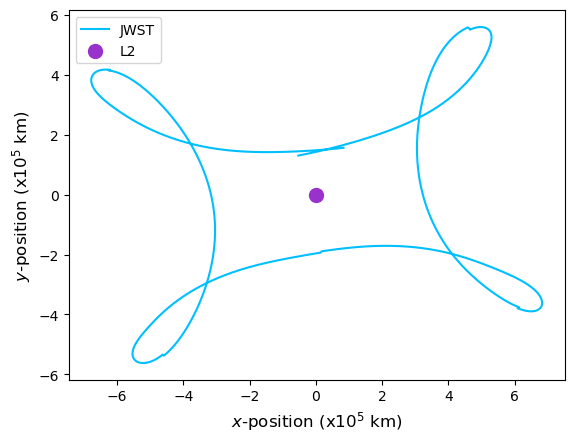

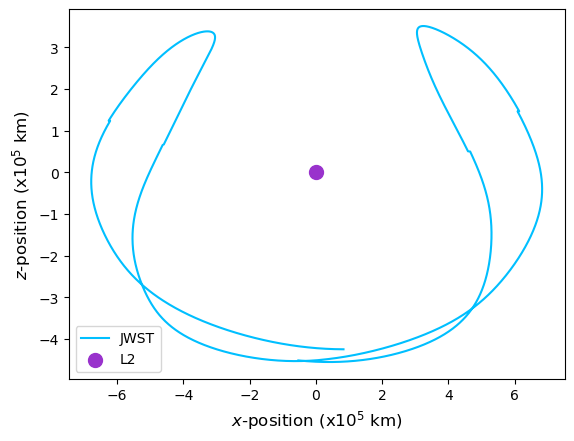

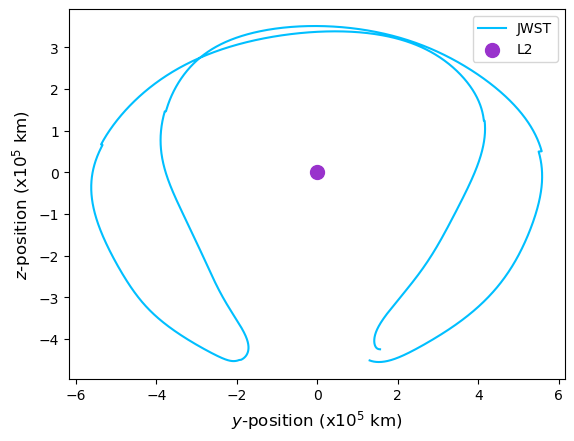

In [30]:
plt.plot(jwst_rel_L2[0]/(1e8), jwst_rel_L2[1]/(1e8), 'deepskyblue', label = 'JWST')
plt.scatter(0, 0, c = 'darkorchid', label = 'L2', s = 100)
plt.xlabel('$x$-position (x10$^5$ km)', size = 12)
plt.ylabel('$y$-position (x10$^5$ km)', size = 12)
plt.legend()
plt.show()


plt.plot(jwst_rel_L2[0]/(1e8), jwst_rel_L2[2]/(1e8), 'deepskyblue', label = 'JWST')
plt.scatter(0, 0, c = 'darkorchid', label = 'L2', s = 100)
plt.xlabel('$x$-position (x10$^5$ km)', size = 12)
plt.ylabel('$z$-position (x10$^5$ km)', size = 12)
plt.legend()
plt.show()


plt.plot(jwst_rel_L2[1]/(1e8), jwst_rel_L2[2]/(1e8), 'deepskyblue', label = 'JWST')
plt.scatter(0, 0, c = 'darkorchid', label = 'L2', s = 100)
plt.xlabel('$y$-position (x10$^5$ km)', size = 12)
plt.ylabel('$z$-position (x10$^5$ km)', size = 12)
plt.legend()
plt.show()

Plot percent error for original and current methods

<Figure size 640x480 with 0 Axes>

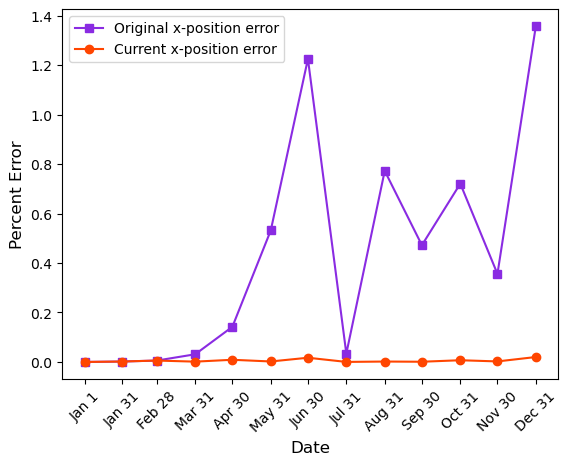

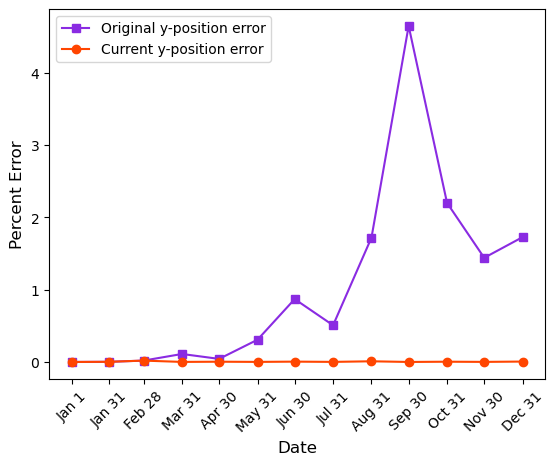

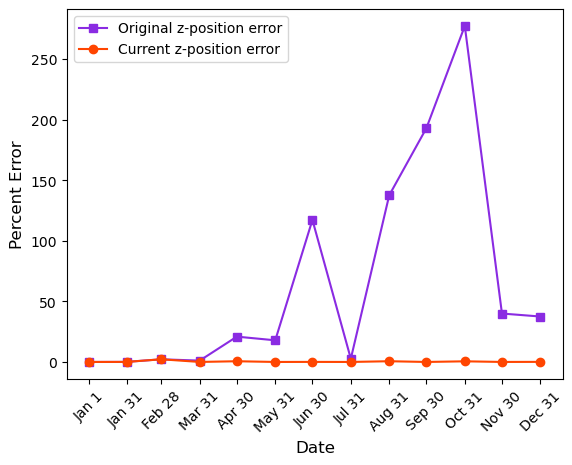

In [31]:
times = np.array([0, 300, 580, 890, 1190, 1500, 1800, 2110, 2420, 2720, 3030, 3330, 3640])
dates = np.array(['Jan 1', 'Jan 31', 'Feb 28', 'Mar 31', 'Apr 30', 'May 31', 'Jun 30', 'Jul 31', 'Aug 31', \
                  'Sep 30', 'Oct 31', 'Nov 30', 'Dec 31'])

test1 = np.array([500, 2000])
test2 = np.array(['hi', 'no'])

x_error = np.array([0., 0.00175947, 0.00568101, 0.00130104, 0.00881467, 0.00196370, 0.01706298, 0.00016797, \
                    0.00169677, 0.00087892, 0.00697028, 0.00216976, 0.01998659])

y_error = np.array([0., 0.00213231, 0.01872010, 0.00065047, 0.00346034, 0.00090489, 0.00455527, 0.00101342, \
                    0.00929219, 0.00003143, 0.00349295, 0.00101009, 0.00551063])

z_error = np.array([0., 0.05254056, 2.20153780, 0.01458724, 0.59112655, 0.00592238, 0.05229131, 0.00871150, \
                    0.60498233, 0.00427292, 0.53399475, 0.01712847, 0.07851278])

x_error_og = np.array([0., 0.00175947, 0.00568102, 0.03101725, 0.14203417, 0.53156937, 1.22481738, 0.03363953, \
                       0.77240536, 0.47196937, 0.72071716, 0.35594000, 1.35805707])

y_error_og = np.array([0., 0.00213231, 0.01872010, 0.11021299, 0.04246728, 0.30738801, 0.86908757, 0.50708086, \
                       1.71836280, 4.64448219, 2.19875018, 1.43970320, 1.72570321])

z_error_og = np.array([0., 0.05254056, 2.20153828, 1.11023538, 20.90592459, 17.87318864, 117.26897934, 2.65601010, \
                       137.61145951, 193.00090683, 277.37877672, 39.97283079, 37.51308936])

fig = plt.figure()
fig, ax = plt.subplots(1,1)
ax.set_xticks(times)
ax.set_xticklabels(dates, minor=False, rotation=45)
ax.plot(times, x_error_og, 'blueviolet', marker = 's', label = 'Original x-position error')
ax.plot(times, x_error, 'orangered', marker = 'o', label = 'Current x-position error')
ax.set_xlabel('Date', size = 12)
ax.set_ylabel('Percent Error', size = 12)
plt.legend()
plt.show()

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks(times)
ax1.set_xticklabels(dates, minor=False, rotation=45)
ax1.plot(times, y_error_og, 'blueviolet', marker = 's', label = 'Original y-position error')
ax1.plot(times, y_error, 'orangered', marker = 'o', label = 'Current y-position error')
ax1.set_xlabel('Date', size = 12)
ax1.set_ylabel('Percent Error', size = 12)
plt.legend()
plt.show()

fig, ax2 = plt.subplots(1,1)
ax2.set_xticks(times)
ax2.set_xticklabels(dates, minor=False, rotation=45)
ax2.plot(times, z_error_og, 'blueviolet', marker = 's', label = 'Original z-position error')
ax2.plot(times, z_error, 'orangered', marker = 'o', label = 'Current z-position error')
ax2.set_xlabel('Date', size = 12)
ax2.set_ylabel('Percent Error', size = 12)
plt.legend()
plt.show()

The runtime for each function can be obtained below. The delta_t values in each of the cells were changed to produce the results shown in our report. The delta_t values that were tested include 100, 1000, 5000, 8640, 10000 seconds.

In [39]:
#FE Runtime
import time
start = time.time()

T = 31536000
delta_t = 10000

u, times = ivp_forward_euler(u_0, T, delta_t)

end = time.time()
print('Execution Time:', end-start)

NameError: name 'u_0' is not defined

In [33]:
#AB2 Runtime
import time
start = time.time()

T = 31536000
delta_t = 10000

u, times = ivp_ab2(u_0, T, delta_t)

end = time.time()
print('Execution Time:', end-start)

NameError: name 'u_0' is not defined

In [37]:
#AB3 Runtime
import time
start = time.time()

T = 31536000
delta_t = 10000

u, times = ivp_ab3(u_0, T, delta_t)

end = time.time()
print('Execution Time:', end-start)

NameError: name 'u_0' is not defined

In [13]:
#AB4 Runtime
import time
start = time.time()

T = 31536000
delta_t = 10000

u, times = ivp_ab4(u_0, T, delta_t)

end = time.time()
print('Execution Time:', end-start)

Execution Time: 4.009427785873413


The error for each of the methods can be found with the following code.

In [36]:
start = time.time()
T = 3.7e5
delta_t = 10
delta_ts = [20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
delta_t_baseline = 10

err_euler = np.zeros(len(delta_ts))
err_ab2 = np.zeros(len(delta_ts))
err_ab3 = np.zeros(len(delta_ts))
err_ab4 = np.zeros(len(delta_ts))

#print(err_euler)
for i in range(len(delta_ts)):
    err_euler[i] = ivp_forward_euler_error(u_0, T, delta_ts[i], delta_t_baseline)
    err_ab2[i] = ivp_ab2_error(u_0, T, delta_ts[i], delta_t_baseline)
    err_ab3[i] = ivp_ab3_error(u_0, T, delta_ts[i], delta_t_baseline)
    err_ab4[i] = ivp_ab4_error(u_0, T, delta_ts[i], delta_t_baseline)
end = time.time()

NameError: name 'u_0' is not defined

In [41]:
print(end - start)

NameError: name 'end' is not defined

C:\Users\Dell\AppData\Local\Temp\ipykernel_11080\2635488650.py:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


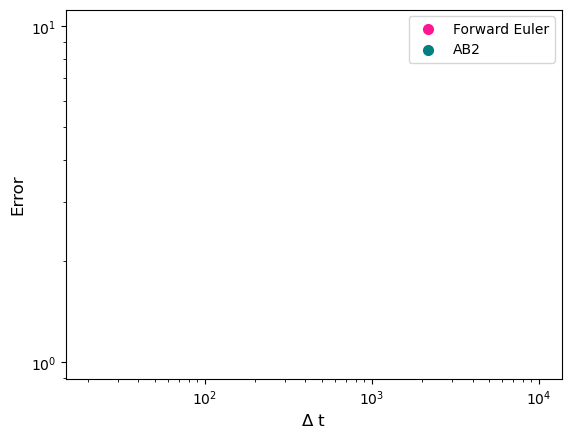

In [40]:
plt.scatter(delta_ts, err_euler, label = 'Forward Euler', linewidths = 2, color = 'deeppink')
plt.scatter(delta_ts, err_ab2, label = 'AB2', linewidths = 2, color = 'teal')

plt.ylabel('Error', size=12)
plt.xlabel('$\Delta$ t', size=12)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

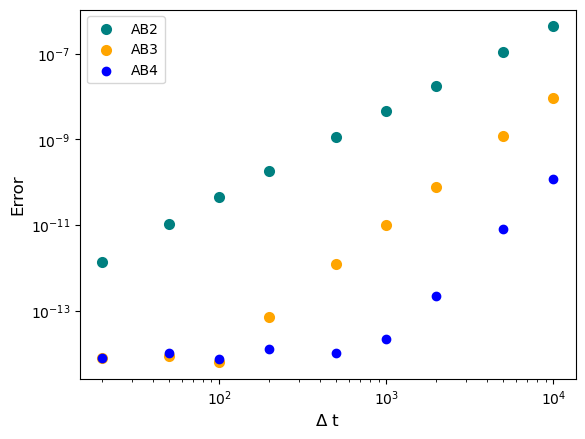

In [20]:
plt.scatter(delta_ts, err_ab2, label = 'AB2', linewidths = 2, color = 'teal')
plt.scatter(delta_ts, err_ab3, label = 'AB3', linewidths = 2, color = 'orange')
plt.scatter(delta_ts, err_ab4, label = 'AB4', linewidths = 1, color='blue')
plt.ylabel('Error', size=12)
plt.xlabel('$\Delta$ t', size=12)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

To show that the error plots converge at the expected rate, the error values are returned in the following cell so that their orders can be compared. For $\Delta$ t values that differ by a factor of 10, the error should scale by a factor relative to its respective order.

In [26]:
print('Error Values for Forward Euler Method:', err_euler[0], err_euler[1], err_euler[2], err_euler[3], err_euler[4], err_euler[5], err_euler[6], err_euler[7], err_euler[8])
print('')
print('Error Values for AB2 Method:', err_ab2[0], err_ab2[1], err_ab2[2], err_ab2[3], err_ab2[4], err_ab2[5], err_ab2[6], err_ab2[7], err_ab2[8])
print('')
print('Error Values for AB3 Method:', err_ab3[0], err_ab3[1], err_ab3[2], err_ab3[3], err_ab3[4], err_ab3[5], err_ab3[6], err_ab3[7], err_ab3[8])
print('')
print('Error Values for AB4 Method:', err_ab4[0], err_ab4[1], err_ab4[2], err_ab4[3], err_ab4[4], err_ab4[5], err_ab4[6], err_ab4[7], err_ab4[8])

Error Values for Forward Euler Method: 9.265321674248548e-08 3.7060678034990717e-07 8.338425230462866e-07 1.760238316734278e-06 4.53882143722657e-06 9.167787463169327e-06 1.841825948760218e-05 4.6111198766782086e-05 9.207876949701362e-05

Error Values for AB2 Method: 1.3447108890324526e-12 1.0788705642989836e-11 4.4508397756523635e-11 1.7933681271603809e-10 1.122159503797621e-09 4.48281527937301e-09 1.787531145379719e-08 1.106568080843935e-07 4.35632518608286e-07

Error Values for AB3 Method: 7.69431664569197e-15 8.67452224278285e-15 6.1813963809969716e-15 6.923288205359142e-14 1.217388853968317e-12 9.767618419150114e-12 7.761334949504271e-11 1.1858908489668959e-09 9.13260874743201e-09

Error Values for AB4 Method: 7.714619102842284e-15 1.0067786660053636e-14 7.366628578279833e-15 1.2360853782479409e-14 1.0232009622026781e-14 2.1943406876527902e-14 2.1958504423151115e-13 7.953459220302386e-12 1.194734408636509e-10


The plots for the regions of stability are shown below. See report for derivation of the equations used in obtaining the regions of stability.

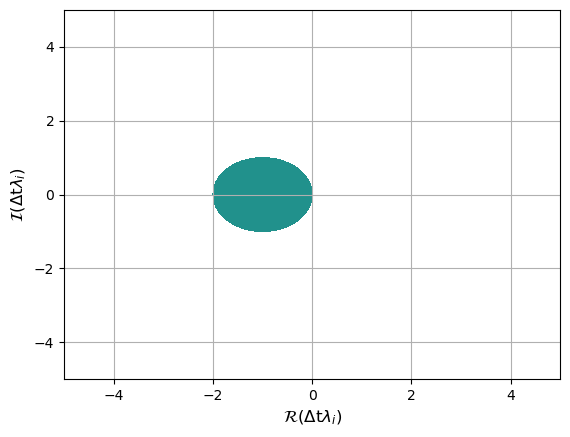

In [27]:
#Forward Euler Stability
import numpy as np

#Setting ranges for real and imaginary components
w_r = np.linspace(-5, 5, 500)
w_i = np.linspace(-5, 5, 500)

[wr, wi] = np.meshgrid(w_r, w_i)

#
FE = abs(1 + wr + wi*1j)
        
plt.contourf(wr, wi, FE, levels=[0,1])
plt.xlabel('$\mathcal{R}$($\Delta$t$\lambda_i$)', fontsize=12)
plt.ylabel('$\mathcal{I}$($\Delta$t$\lambda_i$)', fontsize=12)
plt.grid()

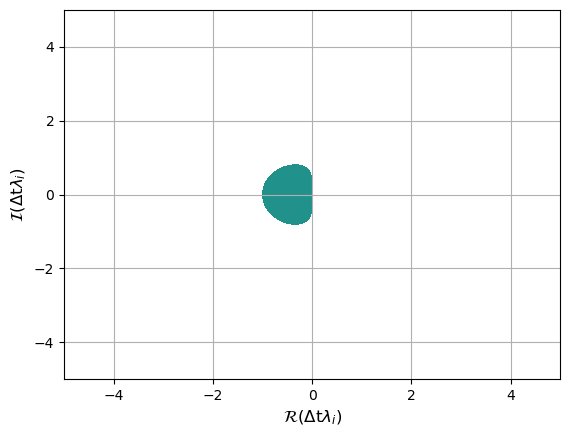

In [29]:
#AB2 Stability
import numpy as np

#Setting ranges for dt+lambda_l
dtl_r = np.linspace(-5, 5, 500)
dtl_i = np.linspace(-5, 5, 500)

[dtlr, dtli] = np.meshgrid(dtl_r, dtl_i)

#representing terms as complex number
dtl = dtlr + dtli*1j

#initialize matrix of roots
r = np.zeros((dtl.shape))

#Finding the roots
for i in range(len(dtl)):
    for k in range(len(dtl)):
        p0 = 1/2*dtl[i, k]
        p1 = -1 - 3/2*dtl[i, k]
        p2 = 1
        r[i, k] = max(abs(np.roots([p2, p1, p0])))

#creating contour plot for locations where roots are less than or equal to 1
plt.contourf(dtlr, dtli, r, levels=[0,1])
plt.xlabel('$\mathcal{R}$($\Delta$t$\lambda_i$)', fontsize=12)
plt.ylabel('$\mathcal{I}$($\Delta$t$\lambda_i$)', fontsize=12)
plt.grid()

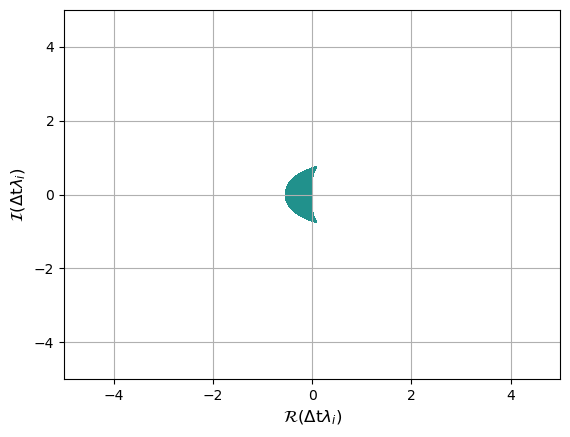

In [30]:
#AB3 Stability
import numpy as np

dtl_r = np.linspace(-5, 5, 500)
dtl_i = np.linspace(-5, 5, 500)

[dtlr, dtli] = np.meshgrid(dtl_r, dtl_i)

dtl = dtlr + dtli*1j

r = np.zeros((dtl.shape))

for i in range(len(dtl)):
    for k in range(len(dtl)):
        p0 = -5/12*dtl[i, k]
        p1 = 4/3*dtl[i, k]
        p2 = -1 - 23/12*dtl[i, k]
        p3 = 1
        r[i, k] = max(abs(np.roots([p3, p2, p1, p0])))
        
plt.contourf(dtlr, dtli, r, levels=[0,1])
plt.xlabel('$\mathcal{R}$($\Delta$t$\lambda_i$)', fontsize=12)
plt.ylabel('$\mathcal{I}$($\Delta$t$\lambda_i$)', fontsize=12)
plt.grid()

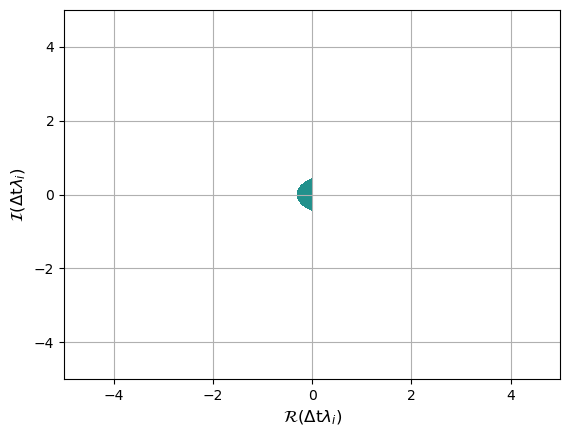

In [60]:
#AB4 Stability
import numpy as np

dtl_r = np.linspace(-5, 5, 500)
dtl_i = np.linspace(-5, 5, 500)

[dtlr, dtli] = np.meshgrid(dtl_r, dtl_i)

dtl = dtlr + dtli*1j

r = np.zeros((dtl.shape))

for i in range(len(dtl)):
    for k in range(len(dtl)):
        p0 = 9/24*dtl[i, k]
        p1 = -37/24*dtl[i, k]
        p2 = 59/24*dtl[i, k]
        p3 = -1 - 55/24*dtl[i, k]
        p4 = 1
        r[i, k] = max(abs(np.roots([p4, p3, p2, p1, p0])))
        
plt.contourf(dtlr, dtli, r, levels=[0,1])
plt.xlabel('$\mathcal{R}$($\Delta$t$\lambda_i$)', fontsize=12)
plt.ylabel('$\mathcal{I}$($\Delta$t$\lambda_i$)', fontsize=12)
plt.grid()

-3.0
-1.0


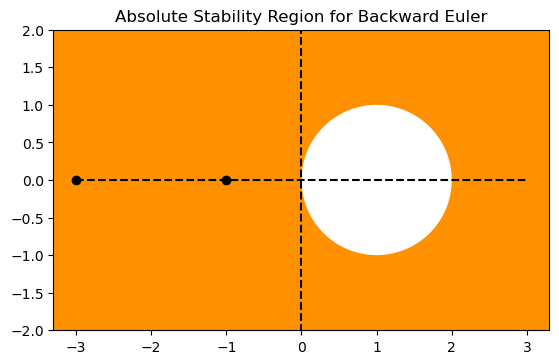

In [5]:
#trapezoid method stability region 
# Plot the region of absolute stability for Backward Euler
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

t = numpy.linspace(0.0, 2.0 * numpy.pi, 100)

K_1 = 3.0
K_2 = 1.0
delta_t = 1.0
eigenvalues = [-K_1, -K_2]

axes.set_facecolor((255.0/255.0,145.0/255.0,0/255.0,1.0))
axes.fill(numpy.cos(t) + 1.0, numpy.sin(t), 'w')
for lam in eigenvalues:
    print(lam * delta_t)
    axes.plot(lam * delta_t, 0.0, 'ko')
axes.plot([-3, 3],[0.0, 0.0],'k--')
axes.plot([0.0, 0.0],[-3, 3],'k--')
# axes.set_xlim((-3, 1))
axes.set_ylim((-2,2))
axes.set_aspect('equal')

axes.set_title("Absolute Stability Region for Backward Euler")
plt.show()

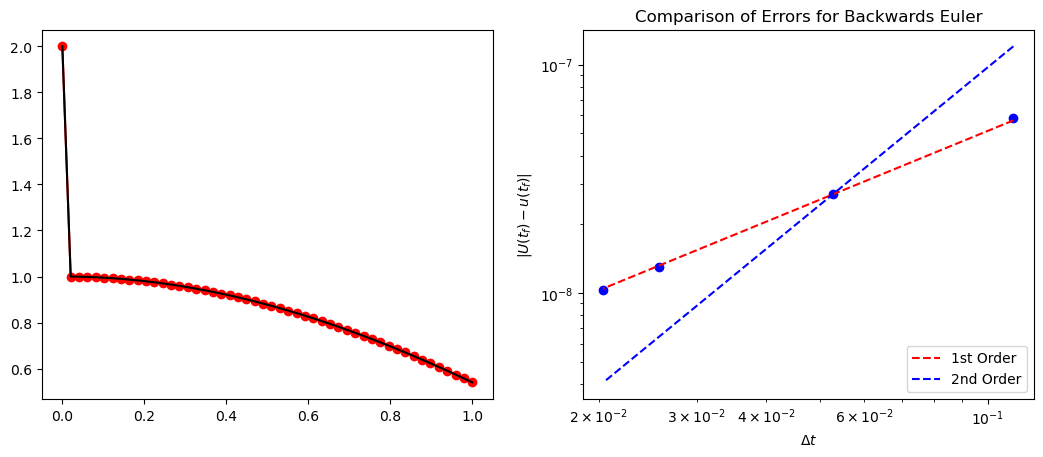

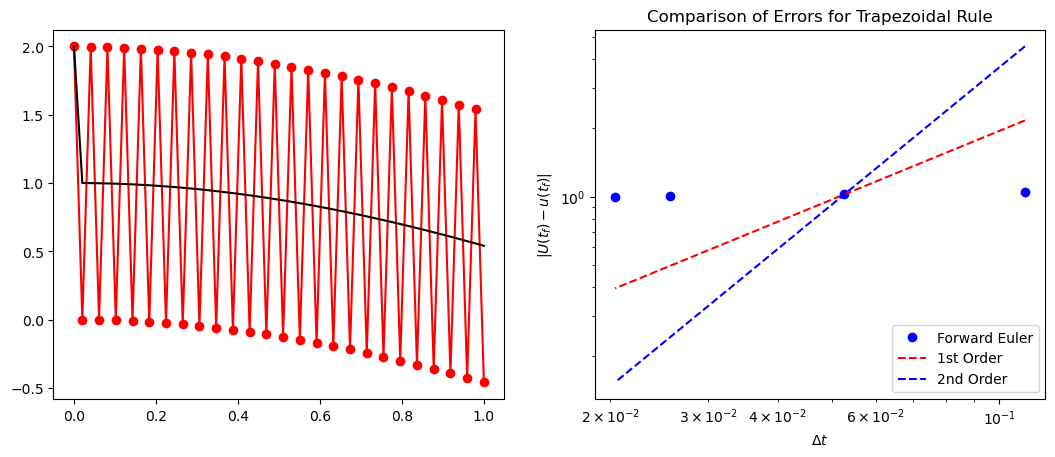

In [6]:
# Compare accuracy between Euler
f = lambda t, lam, u: lam * (u - numpy.cos(t)) - numpy.sin(t)
u_exact = lambda t_0, eta, lam, t: numpy.exp(lam * (t - t_0)) * (eta - numpy.cos(t_0)) + numpy.cos(t)

t_0 = 0.0
t_f = 1.0
eta = 2.0
lam = -1e6

num_steps = [10, 20, 40, 50]
# num_steps = numpy.arange(100, 1000, 100)

delta_t = numpy.empty(len(num_steps))
error_euler = numpy.empty(len(num_steps))
error_trap = numpy.empty(len(num_steps))

for (i, N) in enumerate(num_steps):
    t = numpy.linspace(0, t_f, N)
    delta_t[i] = t[1] - t[0]
    u = u_exact(t_0, eta, lam, t_f)
    
    # Compute Euler solution
    U_euler = numpy.empty(t.shape)
    U_euler[0] = eta
    for (n, t_n) in enumerate(t[1:]):
        U_euler[n+1] = (U_euler[n] - lam * delta_t[i] * numpy.cos(t_n) - delta_t[i] * numpy.sin(t_n)) / (1.0 - lam * delta_t[i])
    error_euler[i] = numpy.abs(U_euler[-1] - u) / numpy.abs(u)
    
    # Compute using trapezoidal
    U_trap = numpy.empty(t.shape)
    U_trap[0] = eta
    for (n, t_n) in enumerate(t[1:]):
        U_trap[n+1] = (U_trap[n] + delta_t[i] * 0.5 * f(t_n, lam, U_trap[n]) - 0.5 * lam * delta_t[i] * numpy.cos(t_n) - 0.5 * delta_t[i] * numpy.sin(t_n)) / (1.0 - 0.5 * lam * delta_t[i])
    error_trap[i] = numpy.abs(U_trap[-1] - u)
    
# Plot error vs. delta_t
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1, 2, 1)
axes.plot(t, U_euler, 'ro-')
axes.plot(t, u_exact(t_0, eta, lam, t),'k')

axes = fig.add_subplot(1, 2, 2)
axes.loglog(delta_t, error_euler, 'bo')
order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_t, order_C(delta_t[1], error_euler[1], 1.0) * delta_t**1.0, 'r--', label="1st Order")
axes.loglog(delta_t, order_C(delta_t[1], error_euler[1], 2.0) * delta_t**2.0, 'b--', label="2nd Order")

axes.legend(loc=4)
axes.set_title("Comparison of Errors for Backwards Euler")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

# Plots for trapezoid
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1, 2, 1)
axes.plot(t, U_trap, 'ro-')
axes.plot(t, u_exact(t_0, eta, lam, t),'k')

axes = fig.add_subplot(1, 2, 2)
axes.loglog(delta_t, error_trap, 'bo', label='Forward Euler')
order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_t, order_C(delta_t[1], error_trap[1], 1.0) * delta_t**1.0, 'r--', label="1st Order")
axes.loglog(delta_t, order_C(delta_t[1], error_trap[1], 2.0) * delta_t**2.0, 'b--', label="2nd Order")

axes.legend(loc=4)
axes.set_title("Comparison of Errors for Trapezoidal Rule")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

plt.show()

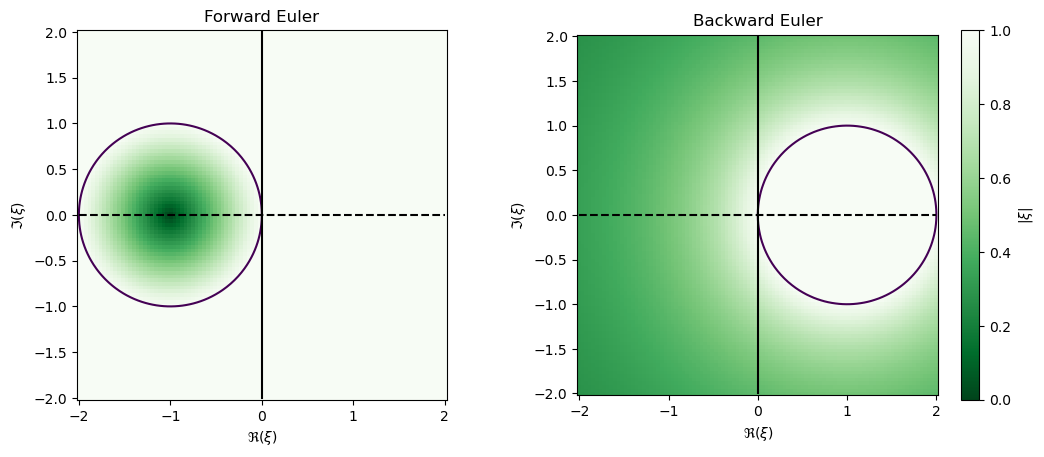

In [7]:
x = numpy.linspace(-2, 2, 100)
y = numpy.linspace(-2, 2, 100)
X, Y = numpy.meshgrid(x, y)
Z = X + 1j * Y

fig, axes = plt.subplots(1, 2)
fig.set_figwidth(fig.get_figwidth() * 2)
pcolor_plot = axes[0].pcolor(X, Y, numpy.abs(1 + Z), vmin=0.0, vmax=1.0, cmap=plt.get_cmap('Greens_r'))
axes[0].contour(X, Y, numpy.abs(1 + Z), levels=[1.0])
axes[0].plot(x, numpy.zeros(x.shape),'k--')
axes[0].plot(numpy.zeros(y.shape), y,'k')
axes[0].set_aspect('equal')
axes[0].set_title("Forward Euler")
axes[0].set_xlabel(r"$\Re(\xi)$")
axes[0].set_ylabel(r"$\Im(\xi)$")

pcolor_plot = axes[1].pcolor(X, Y, numpy.abs(1.0 / (1.0 - Z)), vmin=0.0, vmax=1.0, cmap=plt.get_cmap('Greens_r'))
axes[1].contour(X, Y, numpy.abs(1.0 / (1.0 - Z)), levels=[1.0])
axes[1].plot(x, numpy.zeros(x.shape),'k--')
axes[1].plot(numpy.zeros(y.shape), y,'k')
axes[1].set_aspect('equal')
axes[1].set_title("Backward Euler")
axes[1].set_xlabel(r"$\Re(\xi)$")
axes[1].set_ylabel(r"$\Im(\xi)$")

cbar = fig.colorbar(pcolor_plot)
cbar.set_label(r"$|\xi|$")
plt.show()

Forward Euler's method - Stability region tests
  Inside of circle:  0.0
  Outside of circle:  2.0
Backward Euler's method - Stability region tests
  Inside of circle:  1.0
  Outside of circle:  0.447213595499958
Taylor series method of order 4 - Stability region tests
  Inside of strange region:  0.37500000000000006
  Outside of strange region:  5.0


(-2.0, 2.0)

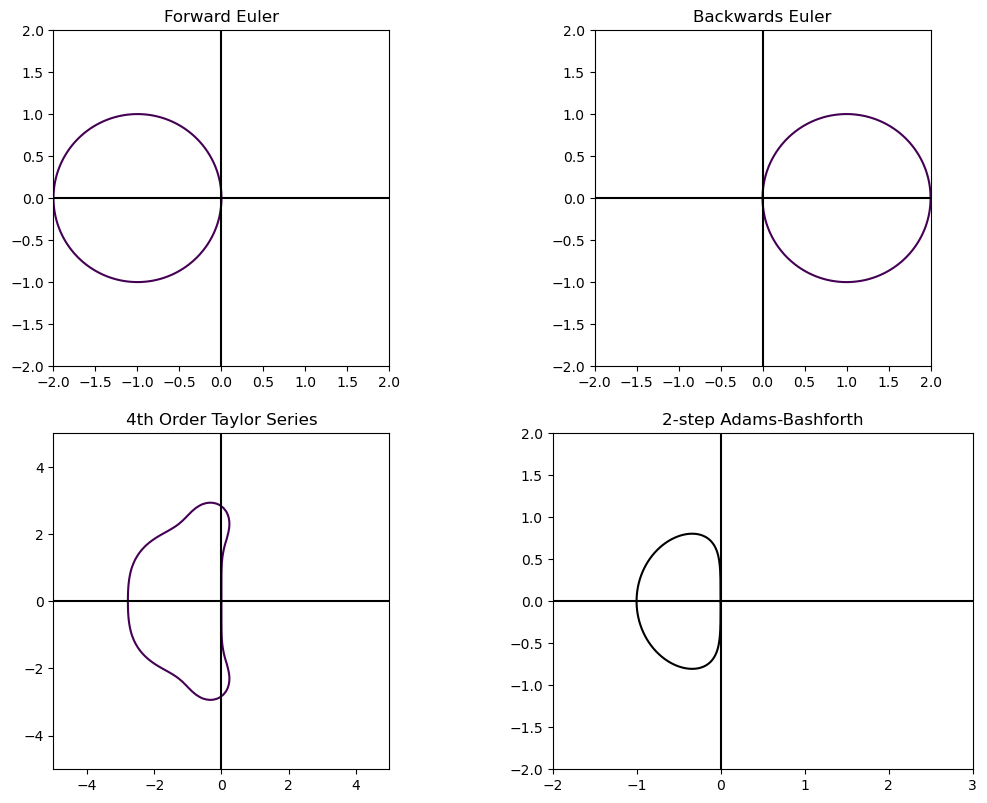

In [8]:
theta = numpy.linspace(0.0, 2.0 * numpy.pi, 100)

# ==================================
#  Forward euler
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
axes = fig.add_subplot(2, 2, 1)
x = numpy.linspace(-2, 2, 100)
y = numpy.linspace(-2, 2, 100)
X, Y = numpy.meshgrid(x, y)
Z = X + 1j * Y

# Evaluate which regions are actually in stability region
print("Forward Euler's method - Stability region tests")
z = -1 + 1j * 0
print("  Inside of circle: ", numpy.abs(1.0 + z))
z = -3 + 1j * 0
print("  Outside of circle: ", numpy.abs(1.0 + z))

axes.contour(X, Y, numpy.abs(1.0 + Z), levels=[1.0])
axes.plot(x, numpy.zeros(x.shape),'k')
axes.plot(numpy.zeros(y.shape), y,'k')
axes.set_aspect('equal')
axes.set_title("Forward Euler")

# ==================================
#  Backwards Euler
axes = fig.add_subplot(2, 2, 2)
x = numpy.linspace(-2, 2, 100)
y = numpy.linspace(-2, 2, 100)
X, Y = numpy.meshgrid(x, y)
Z = X + 1j * Y

# Evaluate which regions are actually in stability region
print("Backward Euler's method - Stability region tests")
z = 1 + 1j
print("  Inside of circle: ", numpy.abs(1.0 / (1.0 - z)))
z = -1 + 1j
print("  Outside of circle: ", numpy.abs(1.0 / (1.0 - z)))

axes.contour(X, Y, numpy.abs(1.0 / (1.0 - Z)), levels=[1.0])
axes.plot(x, numpy.zeros(x.shape),'k')
axes.plot(numpy.zeros(y.shape), y,'k')
axes.set_aspect('equal')
axes.set_title("Backwards Euler")

# ==================================
#  Taylor series method of order 4
axes = fig.add_subplot(2, 2, 3)
x = numpy.linspace(-5, 5, 100)
y = numpy.linspace(-5, 5, 100)
X, Y = numpy.meshgrid(x, y)
Z = X + 1j * Y

# Evaluate which regions are actually in stability region
print("Taylor series method of order 4 - Stability region tests")
z = -1 + 1j * 0
print("  Inside of strange region: ", numpy.abs(1 + z + 0.5 * z**2 + 1.0/6.0 * z**3 + 1.0 / 24.0 * z**4))
z = -4 + 1j * 0
print("  Outside of strange region: ", numpy.abs(1 + z + 0.5 * z**2 + 1.0/6.0 * z**3 + 1.0 / 24.0 * z**4))

axes.contour(X, Y, numpy.abs(1 + Z + 0.5 * Z**2 + 1.0/6.0 * Z**3 + 1.0 / 24.0 * Z**4), levels=[1.0])
axes.plot(x, numpy.zeros(x.shape),'k')
axes.plot(numpy.zeros(y.shape), y,'k')
axes.set_aspect('equal')
axes.set_title("4th Order Taylor Series")

# ==================================
# 2-step Adams-Bashforth
theta = numpy.linspace(0.0, 2.0 * numpy.pi, 1000)
xi = numpy.exp(1j * theta)

rho_2AB = lambda xi: 2.0 * (xi - 1.0) * xi
sigma_2AB = lambda xi: 3.0 * xi - 1.0
z_2AB = rho_2AB(xi) / sigma_2AB(xi)
z = rho_2AB(xi) / sigma_2AB(xi)

axes = fig.add_subplot(2, 2, 4)
axes.plot(z_2AB.real, z_2AB.imag, 'k')
axes.plot(x, numpy.zeros(x.shape),'k')
axes.plot(numpy.zeros(y.shape), y,'k')
axes.set_title("2-step Adams-Bashforth")
axes.set_aspect('equal')
axes.set_xlim([-2, 3])
axes.set_ylim([-2, 2])

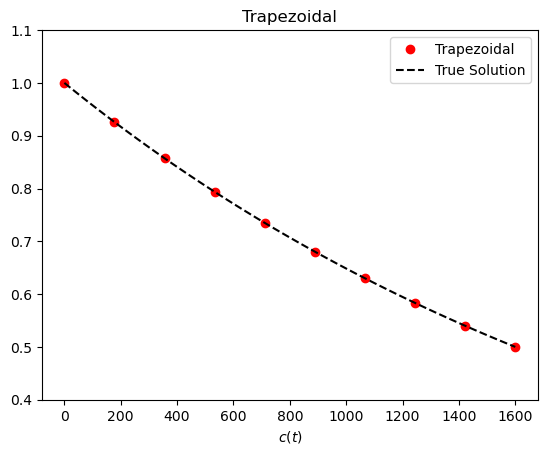

In [9]:
c_0 = 1.0
decay_constant = -numpy.log(2.0) / 1600.0
t_exact = numpy.linspace(0.0, 1.6e3, 100)
u_exact = c_0 * numpy.exp(decay_constant * t_exact)

# Implement trapezoidal method
t = numpy.linspace(0.0, 1.6e3, 10)
delta_t = t[1] - t[0]
u = numpy.empty(t.shape)
u[0] = c_0
integration_constant = (1.0 + decay_constant * delta_t / 2.0) / (1.0 - decay_constant * delta_t / 2.0)
for n in range(t.shape[0] - 1):
    u[n + 1] = u[n] * integration_constant

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, u, 'or', label="Trapezoidal")
axes.plot(t_exact, u_exact, 'k--', label="True Solution")

axes.set_title("Trapezoidal")
axes.set_xlabel("t (years)")
axes.set_xlabel("$c(t)$")
axes.set_ylim((0.4,1.1))
axes.legend()
plt.show()

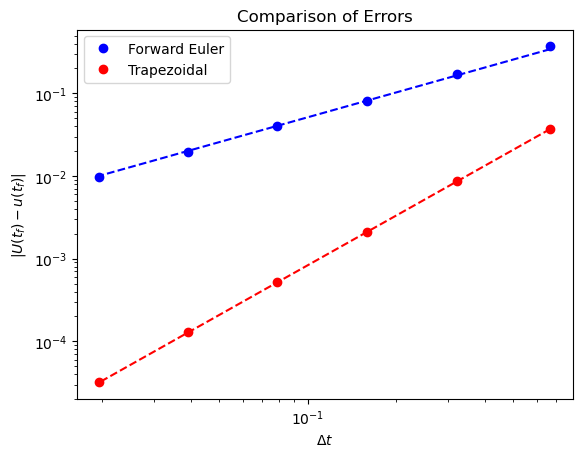

In [11]:
# Compare accuracy between Euler and trap
f = lambda t, u: -u
u_exact = lambda t: numpy.exp(-t)
u_0 = 1.0

t_f = 10.0
num_steps = [2**n for n in range(4,10)]
delta_t = numpy.empty(len(num_steps))
error_euler = numpy.empty(len(num_steps))
error_trap = numpy.empty(len(num_steps))


for (i, N) in enumerate(num_steps):
    t = numpy.linspace(0, t_f, N)
    delta_t[i] = t[1] - t[0]
    
    # Compute Euler solution
    u_euler = numpy.empty(t.shape)
    u_euler[0] = u_0
    for n in range(t.shape[0] - 1):
        u_euler[n+1] = u_euler[n] + delta_t[i] * f(t[n], u_euler[n])
        
    # Compute trapezoidal
    u_trap = numpy.empty(t.shape)
    u_trap[0] = u_0
    integration_constant = (1.0 - delta_t[i] / 2.0) / (1.0 + delta_t[i] / 2.0)
    for n in range(t.shape[0] - 1):
        u_trap[n + 1] = u_trap[n] * integration_constant
        

        
    # Compute error for each
    error_euler[i] = numpy.linalg.norm(delta_t[i] * (u_euler - u_exact(t)), ord=1)
    error_trap[i] = numpy.linalg.norm(delta_t[i] * (u_trap - u_exact(t)), ord=1)

    
# Plot error vs. delta_t
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_t, error_euler, 'bo', label='Forward Euler')
axes.loglog(delta_t, error_trap, 'ro', label='Trapezoidal')


axes.loglog(delta_t, order_C(delta_t[2], error_euler[2], 1.0) * delta_t**1.0, '--b')
axes.loglog(delta_t, order_C(delta_t[2], error_trap[2], 2.0) * delta_t**2.0, '--r')


axes.legend(loc=2)
axes.set_title("Comparison of Errors")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

plt.show()

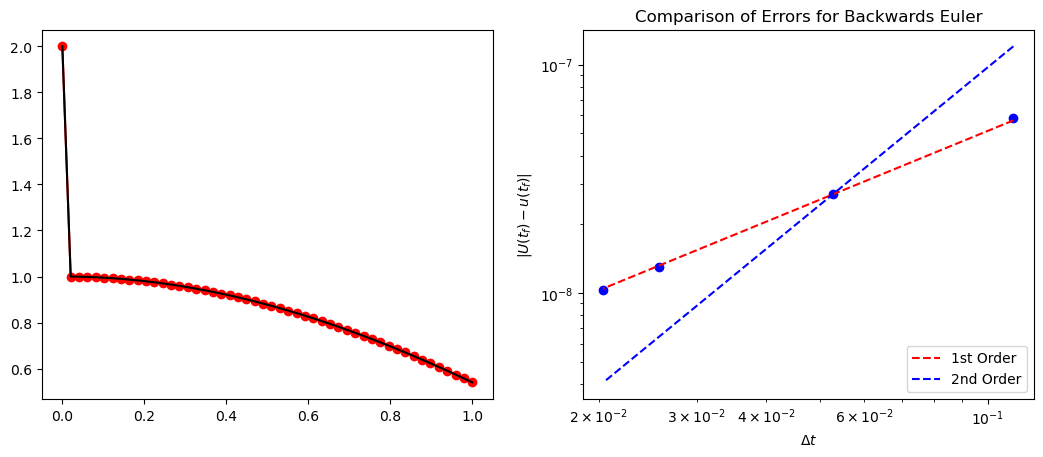

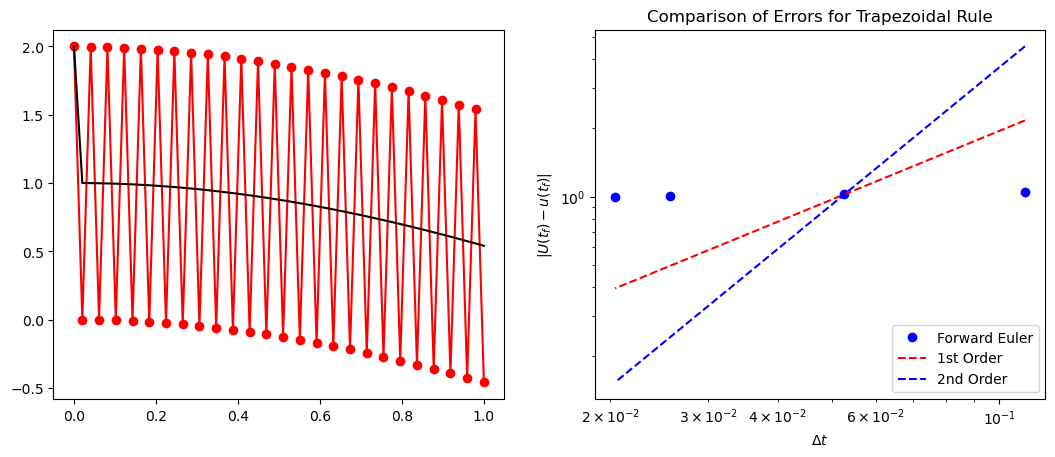

In [12]:
# Compare accuracy between Euler
f = lambda t, lam, u: lam * (u - numpy.cos(t)) - numpy.sin(t)
u_exact = lambda t_0, eta, lam, t: numpy.exp(lam * (t - t_0)) * (eta - numpy.cos(t_0)) + numpy.cos(t)

t_0 = 0.0
t_f = 1.0
eta = 2.0
lam = -1e6

num_steps = [10, 20, 40, 50]
# num_steps = numpy.arange(100, 1000, 100)

delta_t = numpy.empty(len(num_steps))
error_euler = numpy.empty(len(num_steps))
error_trap = numpy.empty(len(num_steps))

for (i, N) in enumerate(num_steps):
    t = numpy.linspace(0, t_f, N)
    delta_t[i] = t[1] - t[0]
    u = u_exact(t_0, eta, lam, t_f)
    
    # Compute Euler solution
    U_euler = numpy.empty(t.shape)
    U_euler[0] = eta
    for (n, t_n) in enumerate(t[1:]):
        U_euler[n+1] = (U_euler[n] - lam * delta_t[i] * numpy.cos(t_n) - delta_t[i] * numpy.sin(t_n)) / (1.0 - lam * delta_t[i])
    error_euler[i] = numpy.abs(U_euler[-1] - u) / numpy.abs(u)
    
    # Compute using trapezoidal
    U_trap = numpy.empty(t.shape)
    U_trap[0] = eta
    for (n, t_n) in enumerate(t[1:]):
        U_trap[n+1] = (U_trap[n] + delta_t[i] * 0.5 * f(t_n, lam, U_trap[n]) - 0.5 * lam * delta_t[i] * numpy.cos(t_n) - 0.5 * delta_t[i] * numpy.sin(t_n)) / (1.0 - 0.5 * lam * delta_t[i])
    error_trap[i] = numpy.abs(U_trap[-1] - u)
    
# Plot error vs. delta_t
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1, 2, 1)
axes.plot(t, U_euler, 'ro-')
axes.plot(t, u_exact(t_0, eta, lam, t),'k')

axes = fig.add_subplot(1, 2, 2)
axes.loglog(delta_t, error_euler, 'bo')
order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_t, order_C(delta_t[1], error_euler[1], 1.0) * delta_t**1.0, 'r--', label="1st Order")
axes.loglog(delta_t, order_C(delta_t[1], error_euler[1], 2.0) * delta_t**2.0, 'b--', label="2nd Order")

axes.legend(loc=4)
axes.set_title("Comparison of Errors for Backwards Euler")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

# Plots for trapezoid
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1, 2, 1)
axes.plot(t, U_trap, 'ro-')
axes.plot(t, u_exact(t_0, eta, lam, t),'k')

axes = fig.add_subplot(1, 2, 2)
axes.loglog(delta_t, error_trap, 'bo', label='Forward Euler')
order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_t, order_C(delta_t[1], error_trap[1], 1.0) * delta_t**1.0, 'r--', label="1st Order")
axes.loglog(delta_t, order_C(delta_t[1], error_trap[1], 2.0) * delta_t**2.0, 'b--', label="2nd Order")

axes.legend(loc=4)
axes.set_title("Comparison of Errors for Trapezoidal Rule")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

plt.show()